In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import io
import sagemaker.amazon.common as smac
import sagemaker
import boto3
from sagemaker import Session
from sklearn.model_selection import train_test_split
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# todo DATA INFO --------------------

In [4]:
'''for this comparsion test I'll bring a well-known "house prices" dataset Let's make a quick check in this dataset, so we can understand better the data,
also we're checking the summary of the dataset with describe, and we need to check if we have missing values'''
# MORE INFO ABOUT THE DATASET: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

'for this comparsion test I\'ll bring a well-known "house prices" dataset Let\'s make a quick check in this dataset, so we can understand better the data,\nalso we\'re checking the summary of the dataset with describe, and we need to check if we have missing values'

In [5]:
df = pd.read_csv('house_prices.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [6]:
# PRINT 1

In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
# PRINT 2

In [9]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [10]:
# PRINT 3

In [11]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


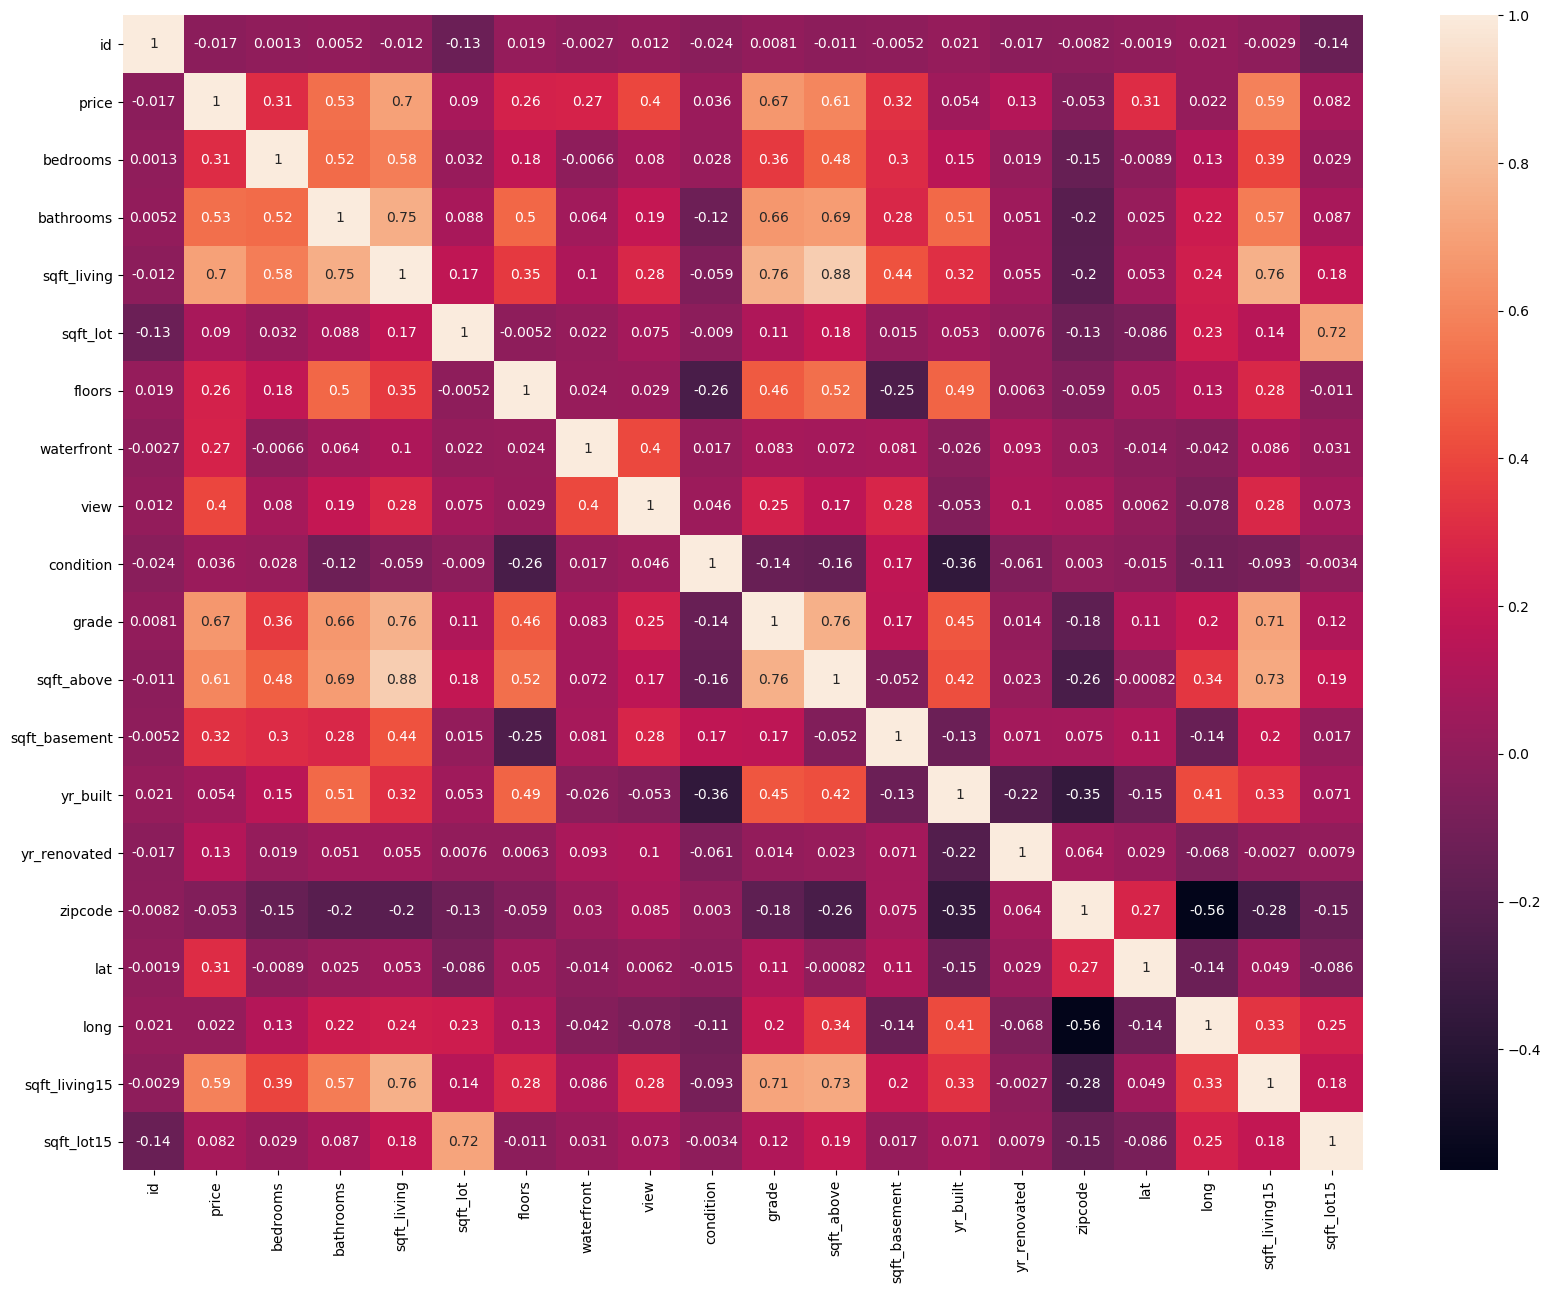

In [12]:
figura = plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

In [13]:
# PRINT 4

In [14]:
# todo ATTRIBUTES SELECTION --------------------

In [15]:
'''Now we need to decide which values we'll choose for the regression model, I'm leaving some rows behing like ID and Date from the dataset and converting for float 32, to make sure
the linear learner will work with no problems, after that we're spliting X and y, leaving 25% of the dataset for test'''

"Now we need to decide which values we'll choose for the regression model, I'm leaving some rows behing like ID and Date from the dataset and converting for float 32, to make sure\nthe linear learner will work with no problems, after that we're spliting X and y, leaving 25% of the dataset for test"

In [16]:
X = df.iloc[:, 3:19].values
y = df.iloc[:, 2].values
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [17]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [18]:
X_training.shape, X_test.shape, y_training.shape, y_test.shape

((15129, 16), (6484, 16), (15129,), (6484,))

In [19]:
# PRINT 5

In [20]:
# todo SAGEMAKER CONF --------------------

In [21]:
'''In this part we must create the path we'll be using in Amazon s3, assign a role to a variable, load a buffer and set to 0, so the linear learner can understand where it should
start, we're also transforming the numpy format and converting it to bytes, which is the way the algorithm in the Amazon standard type of
format (Important: Amazon does the normalization of the dataset for us, so we don't have to do it'''

"In this part we must create the path we'll be using in Amazon s3, assign a role to a variable, load a buffer and set to 0, so the linear learner can understand where it should\nstart, we're also transforming the numpy format and converting it to bytes, which is the way the algorithm in the Amazon standard type of\nformat (Important: Amazon does the normalization of the dataset for us, so we don't have to do it"

In [53]:
session = sagemaker.Session()
bucket = 'tests-aws-sagemaker'
model = 'modelos/house-prices/linear-learner'
dataset = 'datasets/house-prices'
role = sagemaker.get_execution_role()

In [54]:
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_training, y_training)
buffer.seek(0)

0

In [55]:
key = 'houses-train-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(dataset, 'train', key)).upload_fileobj(buffer)

In [56]:
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, dataset, key)

In [57]:
output_location = 's3://{}/{}/output'.format(bucket, model)

In [58]:
# PRINT 6

In [59]:
# todo LINEAR LEARNER CREATION AND TRAINING --------------------

In [60]:
'''Now we can choose the image, session, region, and fill the instance type, define the role and etc (Check SAGEMAKER CONF section),
and after that we're picking our predictor, defining the epochs and the feature_dim which means how many columns we have in our dataset,
then we call the fit for the model so we can deploy right after'''

"Now we can choose the image, session, region, and fill the instance type, define the role and etc (Check SAGEMAKER CONF section),\nand after that we're picking our predictor, defining the epochs and the feature_dim which means how many columns we have in our dataset,\nthen we call the fit for the model so we can deploy right after"

In [61]:
container = sagemaker.image_uris.retrieve(framework = 'linear-learner', region=boto3.Session().region_name)

In [62]:
linear = sagemaker.estimator.Estimator(image_uri = container, role = role, instance_count = 1, instance_type = 'ml.m4.xlarge',
                                       output_path = output_location, sagemaker_session = session, use_stop_instances = True)

In [63]:
linear.set_hyperparameters(feature_dim = 16, predictor_type = 'regressor', num_models = 16)

In [64]:
linear.fit({'train': s3_train_data})

2022-09-12 17:02:00 Starting - Starting the training job...ProfilerReport-1663002120: InProgress
......
2022-09-12 17:03:29 Starting - Preparing the instances for training.........
2022-09-12 17:05:02 Downloading - Downloading input data
2022-09-12 17:05:02 Training - Downloading the training image............
2022-09-12 17:07:03 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2022 17:07:06 INFO 140171106719552] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 

In [ ]:
# PRINT 7

In [ ]:
# todo DEPLOY, PREDICTIONS AND METRICS --------------------

In [ ]:
'''Now we will deploy the model, define the serializer and deserializer, intance type. Once this is done other people can use the instance, let's also prepare
the X_test data for the predictions. We'll have to create a loop so we can transform back in a way sklearn metrics can understand the data'''

In [ ]:
linear_regressor = linear.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

In [ ]:
results = linear_regressor.predict(X_test)
predictions = np.array([r['score'] for r in results['predictions']])

In [ ]:
'''With all that done, mow let's check the MAE, MSE and the RMSE to have a good grasp on how much we're getting close to the real results, since we are comparing the answers the model gave us
with real answers'''

In [ ]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f'MAE: {mae} | MSE:{mse} | RMSE{rmse}')

In [ ]:
# PRINT 8

In [ ]:
'''If you're trying to replicate this code, make sure you delete your endpoint, s3 bucket and turn off your kernel/instance to avoid being charged'''

In [ ]:
# linear_regressor.delete_endpoint()

In [ ]:
'''Now that we know the linear learner answers and capacity a bit better, let's make a comparsion with XGBoost'''